In [23]:
# Import necessary libraries and dependencies
## Basic data manipulation and visualization
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

## Text manipulation
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import math, re, string

## Modeling
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
## Progress bar
from tqdm.auto import tqdm

import warnings
warnings.filterwarnings('ignore')

In [6]:
# Read in text data

reddit_data = pd.read_csv("~/Desktop/Work/Github/_data/Suicide_Detection.csv", index_col = 0).reset_index(drop=True)
reddit_data.head()

,text,class
0,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,Am I weird I don't get affected by compliments...,non-suicide
2,Finally 2020 is almost over... So I can never ...,non-suicide
3,i need helpjust help me im crying so hard,suicide
4,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


In [7]:
print(f"Dataset has {reddit_data.shape[0]} and {reddit_data.shape[1]} columns")
display(reddit_data.info()) #no missing values and both columns are in the right format

Dataset has 232074 and 2 columns
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232074 entries, 0 to 232073
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    232074 non-null  object
 1   class   232074 non-null  object
dtypes: object(2)
memory usage: 3.5+ MB


None

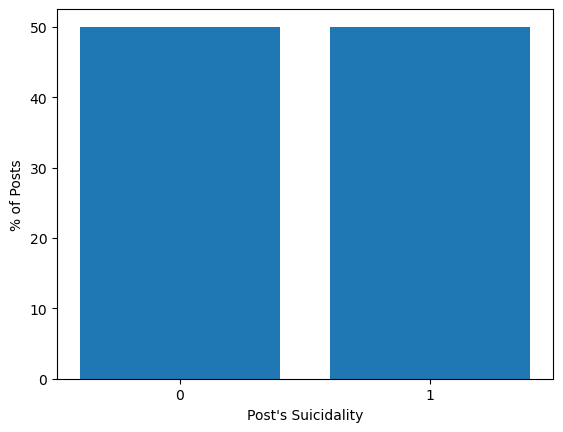

'Class propotions: [0.5 0.5]'

In [8]:
#rename column names
reddit_data.rename(columns = {'text': 'post', 'class':'suicidal'}, inplace=True)

#mapping 1 to suicidal and 0 to non-suicidal posts
reddit_data['suicidal'] = reddit_data['suicidal'].map({'suicide': 1, 'non-suicide':0}) 

#plotting propotion of suicidal vs non-suicidal posts
values, counts = np.unique(reddit_data['suicidal'], return_counts=True)
normalize_counts = counts/counts.sum()

plt.figure()
plt.bar(['0', '1'], normalize_counts*100)
plt.xlabel("Post's Suicidality")
plt.ylabel('% of Posts')
plt.show()

display(f"Class propotions: {normalize_counts}")

In [9]:
#print a sample of 4 posts
np.random.seed(12)
display(reddit_data[['post', 'suicidal']].sample(4).values)

array([['This guy online Is really smart, kind, and everything else youd look for in a guy and he likes me too. The only thing is he lives all the way across the country. I hate this',
        0],
       ['I’m sick of being disrespected by everyoneIt’s over. I’m killing mystic right now. You will never hear from me again',
        1],
       ["Is there a method so easy you could do it in bed?I'm the biggest loser in this world. Only thing I'm good at is sucking at everything. Due to this quarantine thing though, I can't just jump off the nearby condo head first. Is there a method so easy I could do it on my bed? Thanks, and I'll see you in the hell I'm definetly going to.",
        1],
       ["I fucking exist.I do. Hi. Everyone loves abandoning me. Hi. I'm a living human being out here. Is anyone else. I'm going to fucking kill myself if I'm just going to be alone the rest of my life.",
        1]], dtype=object)

## Data Pre-processing and Cleaning

### 1. Dealing with contractions

In [10]:
# In this dataset, the reddit post title is almost always joined to the actual post without any space. For ex: 'I’m sick of being disrespected by everyoneIt’s over' 
# we want to separate "everyoneIt's" into two words "everyone It's"
def split_words(text:str) -> str:
    """ 
    Separate words like "everyoneIt's" to two words "everyone It's"
    """
    return re.sub(r"(.[^\s])([A-Z])", r"\1 \2", text)

reddit_data['post'] = reddit_data['post'].apply(split_words)

In [11]:
## convert all ’ quotation marks to ' so it can be detected by the contraction function
reddit_data['post'] = reddit_data['post'].apply(lambda x: str(x).replace("’", "'"))

## dictionary of common English contractions and their full meaning
contractions_dict = {
"ain't": "is not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"how're": "how are",
"I'd": "I would",
"I'd've": "I would have",
"I'll": "I will",
"I'll've": "I will have",
"I'm": "I am",
"I've": "I have",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"
}

# function to expand contractions
re_pattern = re.compile('(%s)' % '|'.join(contractions_dict.keys()))

def expand_contractions(text: str, contractions_dict=contractions_dict) -> str:
    """
    Takes in a string and a dictionary of contractions and their expansions 
    Returns an expanded string. 
    """
    def replace(match):
        return contractions_dict[match.group(0)]

    return re_pattern.sub(replace, text)

In [12]:
# expand text contractions in the dataset
tqdm.pandas()
reddit_data['post'] = reddit_data['post'].progress_apply(lambda x: expand_contractions(x))

np.random.seed(12)
display(reddit_data[['post', 'suicidal']].sample(4).values) 

100%|██████████| 232074/232074 [00:45<00:00, 5133.28it/s]


array([['This guy online Is really smart, kind, and everything else youd look for in a guy and he likes me too. The only thing is he lives all the way across the country. I hate this',
        0],
       ["I am sick of being disrespected by everyone It's over. I am killing mystic right now. You will never hear from me again",
        1],
       ['Is there a method so easy you could do it in bed? I am the biggest loser in this world. Only thing I am good at is sucking at everything. Due to this quarantine thing though, I cannot just jump off the nearby condo head first. Is there a method so easy I could do it on my bed? Thanks, and I will see you in the hell I am definetly going to.',
        1],
       ['I fucking exist. I do. Hi. Everyone loves abandoning me. Hi. I am a living human being out here. Is anyone else. I am going to fucking kill myself if I am just going to be alone the rest of my life.',
        1]], dtype=object)

### 2. Stemming, tokenization, and stop words

In [13]:
## Stemming
porter = PorterStemmer()            # instatiate porter stemmer

def stem_porter(post: str) -> list:
    """
    Stem words after tokenization.

    Input text is first coverted to tokens then a Porter Stemmer 
    is applied to each token.

    Parameters
    ---------
    post: str
        sentence to be tokinized then stemmed.

    Returns
    ---------
    stemmed_post: list of strings
        stemmed sentence after tokenization.
    """
    stemmed_post = [porter.stem(word) for word in word_tokenize(post)]
    return stemmed_post

## Stop words
en_stop_words = stopwords.words('english')      # load all NLTK stop words

def tokenizer(post: str) -> list:
    """ 
    Preprocess text before vectorization.

    Any form of punctuation is first removed from the input text, while emoticons
    in the text are preserved. For input text is then processed using `stem_porter`
    function and finally outputs the text with no stop words. 

    Parameters
    ----------
    post: str
        post text to be processed
    
    Returns
    ---------
    tokenized: list of strings
        processed text with punctuations or stop words, with emoticons preserved

    See Also
    ---------
    stem_porter: Stem words after tokenization.

    """
    sentence = post.translate(str.maketrans('', '', string.punctuation)).lower()
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', sentence)
    sentence += ' '.join(emoticons).replace('-', '') 
    tokenized = [w for w in stem_porter(sentence) if w not in en_stop_words]

    return tokenized

<function matplotlib.pyplot.show(close=None, block=None)>

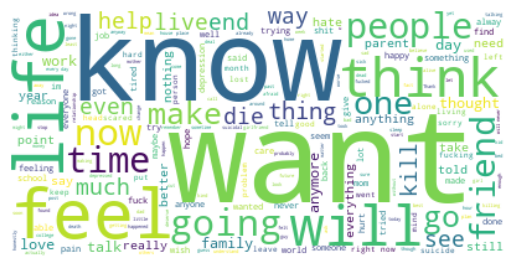

In [14]:
# creating a word cloud
test = reddit_data.copy()

suicidal_posts = test[test.suicidal == 1]
non_suicidal_posts = test[test.suicidal == 0]
suic_word_cloud = " ".join(post for post in suicidal_posts.post)
non_suic_word_cloud = " ".join(post for post in non_suicidal_posts.post)
stop_words = set(STOPWORDS)

word_cloud = WordCloud(stopwords = stop_words, background_color= 'white')

# plt.subplots(nrows = 1, ncols = 2)
# plt.subplot(1, 2, 1)
cloud_gen_suic = word_cloud.generate(suic_word_cloud)
plt.imshow(cloud_gen_suic, interpolation="bilinear")
plt.axis('off')
plt.show

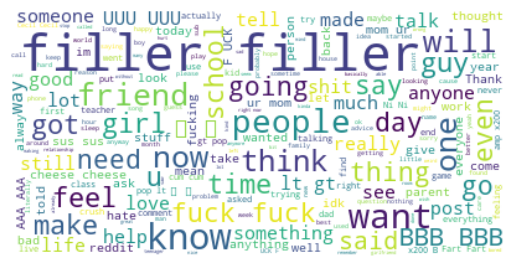

In [15]:
# plt.subplot(1, 2, 2)
cloud_gen_nonsuic = word_cloud.generate(non_suic_word_cloud)
plt.imshow(cloud_gen_nonsuic, interpolation="bilinear")
plt.axis('off')
plt.show()

## Modeling

## Use basic features with CountVectorizer for base accuracies

In [16]:
# create copy of dataset
reddit_df = reddit_data.copy()

# define data and target for our data
X = reddit_df['post']
y = reddit_df['suicidal']

# split data in train, split sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 12)

In [17]:
bag_of_words = CountVectorizer(tokenizer = tokenizer)
X_train_transformed = bag_of_words.fit_transform(X_train)
X_test_tranformed = bag_of_words.transform(X_test)

In [25]:
# Logistic Regression
logreg = LogisticRegression()
logit_accuracy = cross_val_score(logreg, X_train_transformed, y_train, cv = 10, scoring='accuracy')
print(f"Logistic Regression: {logit_accuracy.mean()}")

# KNN
knn_mod = KNeighborsClassifier()
knn_accuracy = cross_val_score(knn_mod, X_train_transformed, y_train, cv = 10, scoring = 'accuracy')
print(f"KNN accuracy: {knn_accuracy.mean()}")

# Decision Tree
tree_mod = DecisionTreeClassifier()
tree_accuracy = cross_val_score(tree_mod, X_train_transformed, y_train, cv = 10, scoring = 'accuracy')
print(f"Decision Tree accuracy: {tree_accuracy.mean()}")

# XGBOOST
xgb_clf = XGBClassifier()
xgb_accuracy = cross_val_score(xgb_clf, X_train_transformed, y_train, cv = 10, scoring = 'accuracy')
print(f"XGBoost accuracy: {xgb_accuracy.mean()}")

# Random Forest
rf_clf = RandomForestClassifier()
rf_accuracy = cross_val_score(rf_clf, X_train_transformed, y_train, cv = 10, scoring = 'accuracy')
print(f"Random Forest accuracy: {rf_accuracy.mean()}")

# SVM
svm_clf = SVC()
svm_accuracy = cross_val_score(svm_clf, X_train_transformed, y_train, cv = 10, scoring = 'accuracy')
print(f"SVM accuracy: {svm_accuracy.mean()}")


Logistic Regression: 0.9245988240891704
KNN accuracy: 0.7782900906412475
Decision Tree accuracy: 0.8484958854563986
XGBoost accuracy: 0.9135678194451596
Random Forest accuracy: 0.8972736675158375


In [15]:
## hyperparameter optimization using solvers, penalty, and c
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'] 
penalty = ['l1','l2']                              
c_values = [100, 10, 1.0, 0.1, 0.01]
# max_iter = [10, 100, 1000]

from sklearn.model_selection import GridSearchCV
grid = dict(solver = solvers, penalty = penalty, C = c_values) # initialize grid search
clf = GridSearchCV(logreg, param_grid = grid, cv = 10, n_jobs = -1, scoring='accuracy')
best_clf = clf.fit(X_train_transformed, y_train)

print(f"Best: {best_clf.best_score_} using {best_clf.best_params_}")

In [ ]:
# Test accuracy
best_clf.score(X_test_tranformed, y_test)

In [40]:
label = {0:'non-suicidal', 1:'suicidal'}

example = ["I hate myself. I am tired of life and I will kill myself"]
X = bag_of_words.transform(example)

print(f'Prediction: %s\nProbability: %.2f%%'
      %(label[logreg.predict(X)[0]],np.max(logreg.predict_proba(X))*100))

Prediction: suicidal
Probability: 87.21%


## KNN

Train set 0.8577663418507735
Test set 0.779799778808727


In [43]:
### KNN parameter optimization
from sklearn.model_selection import GridSearchCV

leaf_size = list(range(1,50))
n_neighbors = list(range(1,30))
p = [1,2]

hyperparams = dict(leaf_size = leaf_size, n_neighbors = n_neighbors, p = p)
knn_tuned = KNeighborsClassifier()
clf = GridSearchCV(knn_tuned, hyperparams, cv = 10, n_jobs=-1)
best_mod = clf.fit(X_train_transformed, y_train)
print(f"Best accuracy: {best_mod.best_score_} using {best_mod.best_params_}")

KeyboardInterrupt: 

## Decision Trees

Train accuracy: 0.9999384429766515
Test accuracy: 0.8501644571477817


In [45]:
## Ensemble Modeling
### Random forest
from sklearn.ensemble import RandomForestClassifier
rd_forest = RandomForestClassifier()
rd_forest.fit(X_train_transformed, y_train)
train_rd_score = rd_forest.score(X_train_transformed, y_train)
test_rd_score = rd_forest.score(X_test_tranformed, y_test)
print(f"Train accuracy: {train_rd_score}")
print(f"Test accuracy: {test_rd_score}")

Train accuracy: 0.9999322872743166
Test accuracy: 0.8977493069818882


In [ ]:
# ensemble models
## bootstrapping: to decrease the variance of the model
## can prevent overfitting since it combines multiple models

## boosting

In [54]:

from sklearn.metrics import accuracy_score

boost_mod = XGBClassifier()
boost_mod.fit(X_train, y_test)
y_pred = boost_mod.predict(X_test)
print(f"Accuracy score : {accuracy_score(y_test, y_pred)} ")

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/ebaraka/opt/anaconda3/envs/suicidal-ideation/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/kp/3kdplpqs5db_hds714vbhvnc0000gp/T/ipykernel_11632/2367034659.py", line 1, in <cell line: 1>
    from xgboost import XGBClassifier
  File "/Users/ebaraka/opt/anaconda3/envs/suicidal-ideation/lib/python3.10/site-packages/xgboost/__init__.py", line 6, in <module>
    from .core import (
  File "/Users/ebaraka/opt/anaconda3/envs/suicidal-ideation/lib/python3.10/site-packages/xgboost/core.py", line 231, in <module>
    _LIB = _load_lib()
  File "/Users/ebaraka/opt/anaconda3/envs/suicidal-ideation/lib/python3.10/site-packages/xgboost/core.py", line 184, in _load_lib
    raise XGBoostError(
xgboost.core.XGBoostError: 
XGBoost Library (libxgboost.dylib) could not be loaded.
Likely causes:
  * OpenMP runtime is not installed
    - vcomp140.

In [ ]:
## feature enginneering
def count_chars(text):
    """
    Takes in a string of text and counts the number of characters
    """
    return len(text)

def count_words(text):
    """
    Takes in a string of text and counts the number of words
    """
    return len(text.split())

def unique_words(text):
    """
    Takes in a string of text and counts the number of unique words
    """
    return(len(set(text.split())))

def question_counts(text):
    """
    Takes in a string of text and counts the number question marks
    """
    return adv.extract_questions(text)['question_mark_counts'][0]

def url(text):
    """
    Takes in a string of text, determines if string starts with 'http', then counts it 
    as a link
    """
    url_count = 0

    text = text.split()
    for i in text:
        if i.startswith('http'):
            url_count += url_count
    return url_count


In [ ]:
reddit_data['number_chars'] = reddit_data['text'].apply(lambda x:count_chars(x))
reddit_data['number_words'] = reddit_data['text'].apply(lambda x:count_words(x))
reddit_data['unique_words'] = reddit_data['text'].apply(lambda x:unique_words(x))
reddit_data['num_questions'] = reddit_data['text'].apply(lambda x:question_counts(x))
reddit_data['url_count'] = reddit_data['text'].apply(lambda x:url(x))

reddit_data.head()

,text,class,number_chars,number_words,unique_words,num_questions,url_count
0,Ex Wife Threatening SuicideRecently I left my ...,suicide,715,143,99,2,0
1,Am I weird I don't get affected by compliments...,non-suicide,138,27,24,0,0
2,Finally 2020 is almost over... So I can never ...,non-suicide,129,26,25,0,0
3,i need helpjust help me im crying so hard,suicide,41,9,9,0,0
4,"I’m so lostHello, my name is Adam (16) and I’v...",suicide,2426,438,254,3,0


In [ ]:
reddit_data.describe()

,number_chars,number_words,unique_words,num_questions,url_count
count,232074.000000,232074.000000,232074.000000,232074.000000,232074.0
mean,689.639736,131.925235,80.065910,0.731254,0.0
std,1156.334007,217.476787,93.782047,23.318268,0.0
min,3.000000,1.000000,1.000000,0.000000,0.0
25%,138.000000,26.000000,23.000000,0.000000,0.0
50%,315.000000,60.000000,47.000000,0.000000,0.0
75%,801.000000,155.000000,104.000000,1.000000,0.0
max,40297.000000,9684.000000,5010.000000,8209.000000,0.0


In [ ]:
reddit_data.drop('url_count', axis = 1, inplace=True)

In [ ]:
reddit_data.columns[2:]

Index(['number_chars', 'number_words', 'unique_words', 'num_questions'], dtype='object')

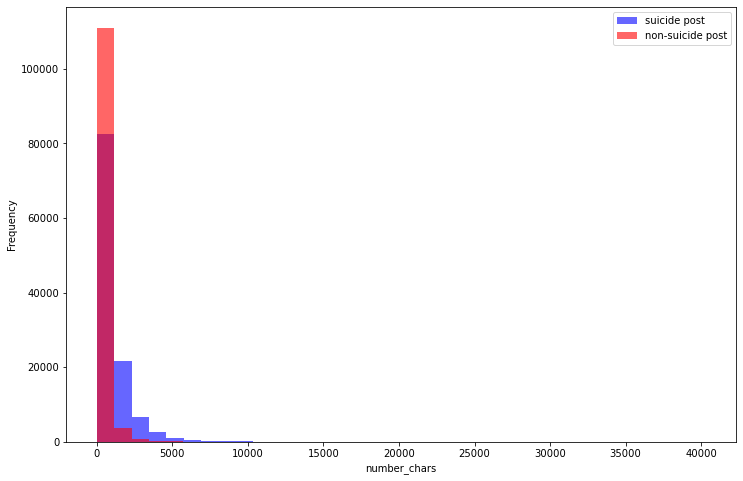

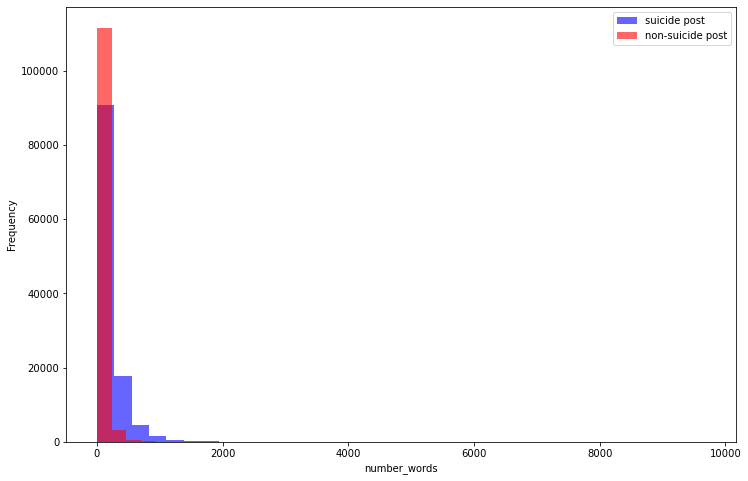

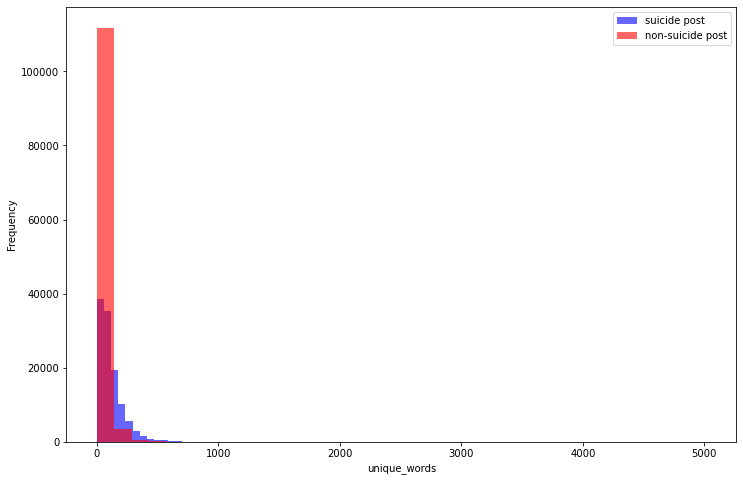

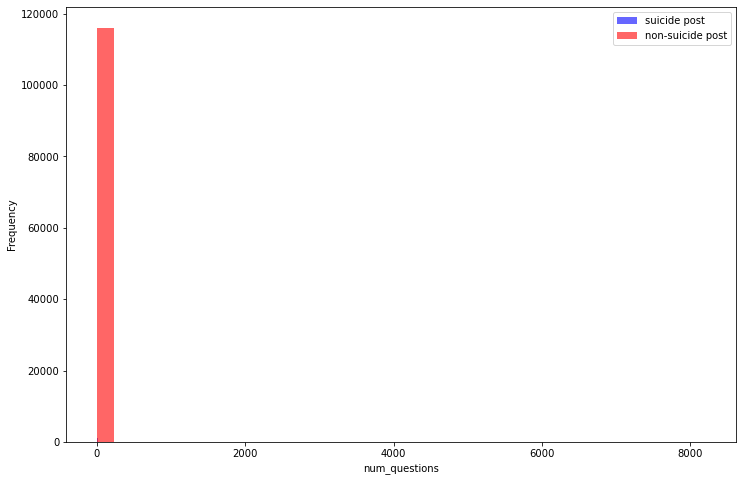

In [ ]:
for col in reddit_data.columns[2:]:
    plt.figure(figsize=(12, 8))
    reddit_data[reddit_data['class']=="suicide"][col].plot(bins=35, kind='hist', color='blue', label='suicide post', alpha=0.6)
    reddit_data[reddit_data['class']=="non-suicide"][col].plot(bins=35, kind='hist', color='red', label='non-suicide post', alpha=0.6)
    plt.xlabel(col)
    plt.legend()
    